In [52]:
import math
import pickle

import random
from collections import defaultdict

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interactive

import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split

%matplotlib inline

In [53]:
DTYPE = tf.float32

In [ ]:
X_data=np.load('./dataset/X_matrix.npy')
Y=pd.read_pickle('./dataset/Y.p')
Data_order=Y.index.values.astype(np.int16)
Y_data=Y.PSI.values.astype(np.float32)
Y_data[Y_data <= 0.10] = 0
Y_data[Y_data >= 0.70] = 1
data_selected = (Y_data == 0) + (Y_data == 1)
x_data = X_data[data_selected]
y_data = Y_data[data_selected]
data_order = Data_order[data_selected]
y_data=y_data.astype(np.int8)

In [ ]:
plt.imshow(x_data[0])
plt.show()

In [ ]:
def display_image(x):
    plt.imshow(x_data[x])

In [ ]:
interactive(display_image, x=IntSlider(min=0,max=x_data.shape[0]-1,step=1,value=0))

## One-Hot Encoding

In [54]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    
    Arguments:
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    encoding = np.eye(2)[x]
    return encoding

In [ ]:
y_data=one_hot_encode(y_data)

## Random Shuffle and Split the Data into 4 Training Batches and 1 Validation

In [56]:
def dump_preprocess_training_batch(X, y, batch_size):
    """
    Save the preprocess batch data and validation data
    
    Arguments:
    : X : features data
    : y : labels data
    : batch_size: the size of training batches
    """
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    y = y[indices]
    
    n_batches=int(X.shape[0]/batch_size)-1
    validation_count = X.shape[0]-batch_size*n_batches
    
    for batch_i in range(0, n_batches):
        features, labels = X[batch_i*batch_size : (batch_i+1)*batch_size], y[batch_i*batch_size : (batch_i+1)*batch_size]
        print(features.shape)
        # Prprocess and save a batch of training data
        filename = './dataset/train_batch_' + str(batch_i+1) + '.p'
        pickle.dump((features, labels), open(filename, 'wb'))
        
    # Use a portion of training batch for validation
    valid_features, valid_labels = X[-validation_count:], y[-validation_count:]
    print(valid_features.shape)
    # Preprocess and Save all validation data
    pickle.dump((valid_features, valid_labels), open('./dataset/validation.p', 'wb'))

In [57]:
#dump_preprocess_training_batch(x_data, y_data, 236)

## Split into Batches with Specific Batch Size

In [58]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [59]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    
    Arguments:
    : batch_id : the id of the batch
    : batch_size : batch size
    
    Returns:
    : the batch features and labels
    """
    filename = './dataset/train_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [60]:
valid_features, valid_labels = pickle.load(open('./dataset/validation.p', mode='rb'))

## Input

In [61]:
def neural_net_input(image_shape, n_classes):
    """
    Grouping nodes into a single name scope in the computation graph.
    
    Arguments:
    : image_shape: The shape of image
    : n_classes: The number of classes
    
    Returns:
    : x, y, keep_prob_1, keep_prob_2, learning_rate, is_training
    """
    with tf.name_scope('inputs'):
        x = tf.placeholder(DTYPE, [None] + list(image_shape), name='x')
        y = tf.placeholder(DTYPE, [None ,n_classes], name='y')
        keep_prob_1 = tf.placeholder(DTYPE, None, name="keep_prob_1")
        keep_prob_2 = tf.placeholder(DTYPE, None, name="keep_prob_2")
        learning_rate = tf.placeholder(DTYPE, None, "lr")
        is_training=tf.placeholder(tf.bool, None, name='is_training')
    return x, y, keep_prob_1, keep_prob_2, learning_rate, is_training

## 1D Convolution

In [62]:
def conv1d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, is_training, padding = 'SAME', l2_regularize=True, wd=0.0001):
    """
    Apply 1D convolution to x_tensor
    
    Arguments:
    : x_tensor: TensorFlow Tensor
    : conv_num_outputs: Number of outputs for the convolutional layer
    : conv_ksize: Kernal size for the convolutional layer
    : conv_strides: Stride for convolution
    : is_training: Placeholder bool that hold the flag to determine training is True or False
    : l2_regularize: Flag for l2 regularization
    : wd: Weight decay
    
    Returns:
    : A tensor that represents convolution of x_tensor
    """
    X_shape = x_tensor.get_shape().as_list()
    #print(X_shape)
    C_kshape = list((conv_ksize,) + (X_shape[-1],) + (conv_num_outputs,))
    #print(C_kshape)
    
    # The shape of the filter weight is (depth, height, width, input_channels, output_channels)
    # The shape of the filter bias is (output_channels,)
    F_W = tf.get_variable('W', shape=C_kshape, initializer=tf.contrib.layers.xavier_initializer(), dtype=DTYPE)
    #F_b = tf.get_variable('b', shape=(conv_num_outputs,) , initializer=tf.constant_initializer(0.1, dtype=DTYPE))
    #print(F_W.shape)
    #print(F_b.shape)
    if l2_regularize==True:
        #wd = 0.0001
        weight_decay = tf.multiply(tf.nn.l2_loss(F_W), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    
    # The shape of the convolution stride is (batch_size, depth, height, width, channels)
    C_strides = conv_strides
    
    # The padding, either 'VALID' or 'SAME'.
    #padding = 'SAME'
    conv_output = tf.nn.conv1d(x_tensor, F_W, C_strides, padding)
    conv_output = tf.layers.batch_normalization(inputs=conv_output, training=is_training)
    conv_output = tf.nn.elu(conv_output)
    # Keeping track of weights and biases
    tf.summary.histogram('weights', F_W)
    #tf.summary.histogram('biases', F_b)
    
    return conv_output

## 1D Maxpooling

In [63]:
def max_pooling1d(x_tensor, pool_ksize, pool_strides):
    """
    Apply 1D pooling to x_tensor
    
    Arguments:
    : x_tensor: TensorFlow Tensor
    : pool_ksize: Kernal size for pool
    : pool_strides: Stride for pool
    
    Returns:
    : A tensor that represents max pooling of x_tensor
    """
   # The padding, either 'VALID' or 'SAME'.
    padding = 'SAME'
    P_kshape = pool_ksize
    P_stride = pool_strides
    
    pooling_output = tf.layers.max_pooling1d(x_tensor,P_kshape,P_stride,padding)
    
    return pooling_output

## Flatten Layer

In [64]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Size)
    
    Arguments:
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the 2D dimensions
    
    Returns:
    : A tensor of size (Batch Size, Flattened Size)
    """
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    X_shape = x_tensor.get_shape().as_list()
    
    return tf.reshape(x_tensor,[-1,np.prod(X_shape[1:])])

## Fully-Connected Layer

In [65]:
def fully_conn(x_tensor, num_outputs, is_training, l2_regularize=True, wd=0.0001):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    
    Arguments:
    : x_tensor: A 2-D tensor where the first dimension is batch size
    : num_outputs: The number of output that the new tensor should be
    : is_training: Placeholder bool that hold the flag to determine training is True or False
    : l2_regularize: Flag for l2 regularization
    
    Returns:
    : A 2-D tensor where the second dimension is num_outputs
    """
    X_shape = x_tensor.get_shape().as_list()
    shape = list((X_shape[-1],)+(num_outputs,))
    
    
    W = tf.get_variable('W', shape=shape, initializer=tf.contrib.layers.xavier_initializer(),dtype=DTYPE)
    #b = tf.get_variable('b', shape=(num_outputs,) , initializer=tf.constant_initializer(0.1, dtype=DTYPE))
    
    if l2_regularize==True:
        #wd = 0.0001
        weight_decay = tf.multiply(tf.nn.l2_loss(W), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    
    fc_output = tf.matmul(x_tensor, W)
    fc_output = tf.layers.batch_normalization(inputs=fc_output, training=is_training)
    fc_output = tf.nn.elu(fc_output)
    
    # Keeping track of weights and biases
    tf.summary.histogram('weights', W)
    #tf.summary.histogram('biases', b)
    
    return fc_output

## Output Layer

In [66]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    
    Arguments:
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    
    Returns:
    : A 2-D tensor where the second dimension is num_outputs.
    """
    X_shape = x_tensor.get_shape().as_list()
    shape = list((X_shape[-1],)+(num_outputs,))
    W = tf.get_variable('W', shape=shape, initializer=tf.contrib.layers.xavier_initializer(),dtype=DTYPE)
    #b = tf.get_variable('b', shape=(num_outputs,) , initializer=tf.constant_initializer(0.1, dtype=DTYPE))
    # Keeping track of weights and biases
    tf.summary.histogram('weights', W)
    #tf.summary.histogram('biases', b)
    return tf.matmul(x_tensor, W)

## Global-Average-Pooling Layer

In [67]:
def global_avg_pooling(x_tensor):
    """
    Apply a Global-Average-Pooling Layer to x_tensor
    
    Arguments:
    : x_tensor: A 2-D tensor where the first dimension is batch size
    
    Returns:
    : A 2-D tensor where the second dimension is num_outputs
    """
    X_shape = x_tensor.get_shape().as_list()
    pool_size = X_shape[1]
    output = tf.layers.average_pooling1d(inputs=x_tensor, pool_size=pool_size, strides=1)
    output_shape = output.get_shape().as_list()
    
    return tf.reshape(output,[-1,np.prod(output_shape[1:])])

## 1D Zero Padding

In [68]:
def zero_padding1d(x_tensor, pad):
    """
    Apply 1D zero padding to x_tensor
    
    Arguments:
    : x_tenor: TensorFlow Tensor
    : pad: The pad size
    
    Returns:
    : A tensor that represents zero padding of x_tensor
    """
    paddings = tf.constant([[0,0], [pad, pad], [0,0]])
    zero_padding_output = tf.pad(x_tensor, paddings, mode='CONSTANT', constant_values=0)
    return zero_padding_output

## *THE Following are the Blocks used in ResNet Architecture. But I don't ues ResNet finally*

If they are used, please comment out the two lines:

"conv_output = tf.layers.batch_normalization(inputs=conv_output, training=is_training)" and "conv_output = tf.nn.elu(conv_output)" in conv1d function,

and take off the "is_training" parameter.

## Identity block

In [69]:
def identity_block(X, f, filters, stage, block, is_training, l2_regularize=True, wd=0.0001):
    """
    Implementation of the identity block
    
    Arguments:
    : X: Input tensor of shape (m, n_S_prev, n_C_prev)
    : f: Integer, specifying the shape of the middle CONV's window for the main path
    : filters: Python list of integers, defining the number of filters in the CONV layers of the main path
    : stage: Integer, used to name the layers, depending on their position in the network
    : block: String/character, used to name the layers, depending on their position in the network
    : is_training: Placeholder bool that hold the flag to determine training is True or False
    
    Returns:
    : Output of the identity block, tensor of shape (m, n_S, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    with tf.variable_scope(conv_name_base + '2a'):
        X = conv1d(X, conv_num_outputs=F1, conv_ksize=1, conv_strides=1, padding ='VALID', l2_regularize=l2_regularize, wd=wd)
    with tf.variable_scope(bn_name_base + '2a'):
        X = tf.layers.batch_normalization(X, training=is_training)
    X = tf.nn.elu(X)
    
    # Second component of main path
    with tf.variable_scope(conv_name_base + '2b'):
        X = conv1d(X, conv_num_outputs=F2, conv_ksize=f, conv_strides=1, padding ='SAME', l2_regularize=l2_regularize, wd=wd)
    with tf.variable_scope(bn_name_base + '2b'):
        X = tf.layers.batch_normalization(X, training=is_training)
    X = tf.nn.elu(X)

    # Third component of main path
    with tf.variable_scope(conv_name_base + '2c'):
        X = conv1d(X, conv_num_outputs=F3, conv_ksize=1, conv_strides=1, padding ='VALID', l2_regularize=l2_regularize, wd=wd)
    with tf.variable_scope(bn_name_base + '2c'):
        X = tf.layers.batch_normalization(X, training=is_training)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    #X = X + X_shortcut
    X = tf.add(X, X_shortcut)
    X = tf.nn.elu(X)
    
    return X

## Convolutional block

In [70]:
def convolutional_block(X, f, filters, stage, block, s , is_training, l2_regularize=True, wd=0.0001):
    """
    Implementation of the convolutional block
    
    Arguments:
    : X: Input tensor of shape (m, n_S_prev, n_C_prev)
    : f: Integer, specifying the shape of the middle CONV's window for the main path
    : filters: Python list of integers, defining the number of filters in the CONV layers of the main path
    : stage: Integer, used to name the layers, depending on their position in the network
    : block: String/character, used to name the layers, depending on their position in the network
    : is_training: Boolean flag for BN
    : s: Integer, specifying the stride to be used
    : is_training: Placeholder bool that hold the flag to determine training is True or False\
    
    
    Returns:
    : output of the convolutional block, tensor of shape (m, n_S, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path
    with tf.variable_scope(conv_name_base + '2a'):
        X = conv1d(X, conv_num_outputs=F1, conv_ksize=1, conv_strides=s, padding ='VALID', l2_regularize=l2_regularize, wd=wd)
    with tf.variable_scope(bn_name_base + '2a'):
        X = tf.layers.batch_normalization(X, training=is_training)
    X = tf.nn.elu(X)

    # Second component of main path (≈3 lines)
    with tf.variable_scope(conv_name_base + '2b'):
        X = conv1d(X, conv_num_outputs=F2, conv_ksize=f, conv_strides=1, padding ='SAME', l2_regularize=l2_regularize, wd=wd)
    with tf.variable_scope(bn_name_base + '2b'):
        X = tf.layers.batch_normalization(X, training=is_training)
    X = tf.nn.elu(X)

    # Third component of main path (≈2 lines)
    with tf.variable_scope(conv_name_base + '2c'):
        X = conv1d(X, conv_num_outputs=F3, conv_ksize=1, conv_strides=1, padding ='VALID', l2_regularize=l2_regularize, wd=wd)
    with tf.variable_scope(bn_name_base + '2c'):
        X = tf.layers.batch_normalization(X, training=is_training)

    ##### SHORTCUT PATH #### (≈2 lines)
    with tf.variable_scope(conv_name_base + '1'):
        X_shortcut = conv1d(X_shortcut, conv_num_outputs=F3, conv_ksize=1, conv_strides=s, padding ='VALID', l2_regularize=l2_regularize, wd=wd)
    with tf.variable_scope(bn_name_base + '1'):
        X_shortcut = tf.layers.batch_normalization(X_shortcut, training=is_training)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tf.add(X, X_shortcut)
    X = tf.nn.elu(X)
    
    return X

## Create Model

In [71]:
def DeepTf(X, keep_prob_1, keep_prob_2, is_training=False):
    """
    Create a convolutional/dense neural network model
    
    Arguments:
    : x: Placeholder tensor that holds data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : is_training: Placeholder bool that hold the flag to determine training is True or False, default is False
    
    Returns:
    : Tensor that represents logits
    """
    

    with tf.name_scope("DNN"):
        
        X = flatten(X)
        
        with tf.variable_scope('fc1'):
            X = fully_conn(X, num_outputs=128, is_training= is_training, l2_regularize=True, wd=0.01)
            X = tf.nn.dropout(X, keep_prob_1)
        with tf.variable_scope('fc2'):
            X = fully_conn(X, num_outputs=256, is_training = is_training, l2_regularize=True, wd=0.01)
            X = tf.nn.dropout(X, keep_prob_1)
        with tf.variable_scope('fc3'):
            X = fully_conn(X, num_outputs=512, is_training = is_training, l2_regularize=True, wd=0.01)
            X = tf.nn.dropout(X, keep_prob_2)
        with tf.variable_scope('fc4'):
            X = fully_conn(X, num_outputs=1024, is_training = is_training, l2_regularize=True, wd=0.01)
            X = tf.nn.dropout(X, keep_prob_2)
            
        X = output(X, 2)
    
    """
    
    with tf.name_scope("CNN"):
    
        with tf.variable_scope('conv1'):
            X = conv1d(X, conv_num_outputs=128, conv_ksize=7, conv_strides=1, is_training=is_training, padding = 'SAME', l2_regularize=True, wd=0.001)
            X = max_pooling1d(X, pool_ksize=3, pool_strides=1)
            X = tf.nn.dropout(X, keep_prob_2)

        X = flatten(X)
        
        with tf.variable_scope('fc1'):
            X = fully_conn(X, num_outputs=128, is_training= is_training, l2_regularize=True, wd=0.001)
            X = tf.nn.dropout(X, keep_prob_2)
        with tf.variable_scope('fc2'):
            X = fully_conn(X, num_outputs=256, is_training = is_training, l2_regularize=True, wd=0.001)
            X = tf.nn.dropout(X, keep_prob_2)
            
        X = output(X, 2)
    """
    
    return X

## Building a training op

In [72]:
def build_op():
    # Remove previous weights, bias, inputs, etc..
    tf.reset_default_graph()

    # Inputs
    x, y, keep_prob_1, keep_prob_2, lr, is_training = neural_net_input((307, 2500), 2)
    # Model
    logits = DeepTf(x, keep_prob_1, keep_prob_2, is_training)
    
    global_step = tf.Variable(0)
    
    # Name logits Tensor, so that is can be loaded from disk after training
    with tf.name_scope('logits'):
        logits = tf.identity(logits, name='logits')

    # Loss and Optimizer
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y), name='cost')
        tf.add_to_collection('losses', cost)
        cost_with_l2 = tf.add_n(tf.get_collection('losses'), name='cost_with_l2')
    
    loss_summ = tf.summary.scalar('loss_with_l2', cost_with_l2)
    loss_summ = tf.summary.scalar('loss', cost)

    
    #with tf.name_scope('cost'):
    #    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
    #loss_summ = tf.summary.scalar('loss', cost)
    
    with tf.name_scope('train'):
        
        # batch normalization in tensorflow requires this update dependency
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost_with_l2, global_step=global_step)
    
    #tf.add_to_collection('cost_op', cost)
    #tf.add_to_collection('train_op', optimizer)
    
    # Accuracy
    with tf.name_scope('predictions'):
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, DTYPE), name='accuracy')
    accuracy_summ = tf.summary.scalar('accuracy', accuracy)
    
    #summary = tf.summary.merge([loss_summ, accuracy_summ], name='summary')
    #Alternatively, you can use tf.summary.merge_all()
    summary = tf.summary.merge_all()
    
    return x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training

## Train the Neural Network

In [73]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch, learn_rate_value):
    """
    Optimize the session on a batch of images and labels
    
    Arguments:
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, 
                                      keep_prob_1:keep_probability[0], keep_prob_2:keep_probability[1], 
                                      lr:learn_rate_value, is_training:True})

## Show Stats

In [74]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, learn_rate_value, valid=None):
    """
    Print information about loss and validation accuracy
    
    Arguments:
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    if type(valid)==tuple:
        train_loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob_1:1.0, keep_prob_2:1.0,
                                        lr:learn_rate_value, is_training: True})
        train_acc = sess.run(accuracy, feed_dict={x: feature_batch, y: label_batch, keep_prob_1:1.0, keep_prob_2:1.0,
                                              lr:learn_rate_value, is_training: True})
        
        val_loss = session.run(cost, feed_dict={x:valid[0], y:valid[1], keep_prob_1:1.0, keep_prob_2:1.0,
                                        lr:learn_rate_value, is_training: False})
        val_acc = sess.run(accuracy, feed_dict={x: valid[0], y: valid[1], keep_prob_1:1.0, keep_prob_2:1.0,
                                              lr:learn_rate_value, is_training: False})
        
        print('Loss: {:>10.4f} Accuracy: {:.4f} ----- Valid Loss: {:>10.4f} Valid Accuracy: {:.4f}'
              .format(train_loss, train_acc, val_loss, val_acc))
    else:
        train_loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob_1:1.0, keep_prob_2:1.0,
                                        lr:learn_rate_value, is_training: True})
        train_acc = sess.run(accuracy, feed_dict={x: feature_batch, y: label_batch, keep_prob_1:1.0, keep_prob_2:1.0,
                                              lr:learn_rate_value, is_training: True})
        
        print('Loss: {:>10.4f} Accuracy: {:.4f}'.format(train_loss, train_acc))

## Hyperparameters

In [75]:
# Tune Parameters
epochs = 12
batch_size = 128
keep_probability = [0.5, 0.2]
learning_rate_init = 0.001

## Train on a Single Batch

In [ ]:
print('Checking the Training on a Single Batch...')

x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training = build_op()

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    # Training cycle
    learning_rate = learning_rate_init
    for epoch in range(epochs):
        
        batch_i = 1
        
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, learning_rate)
        
        print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy, learning_rate, valid=(valid_features, valid_labels))

## Train the Model

In [ ]:
save_model_path = './DeepTF_Model/model2'

x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training = build_op()
print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    learning_rate = learning_rate_init
    for epoch in range(epochs):
        
        n_batches = 12
        index = np.array(range(n_batches))+1
        np.random.shuffle(index)
        
        for batch_i in index : # range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, learning_rate)

            print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy, learning_rate, valid=(valid_features, valid_labels))
    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

In [ ]:
x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training = build_op()

print('Training...')
with tf.Session() as sess:
    steps = 0
    counter = 0
    learning_rate = learning_rate_init
    # Initializing the variables
    sess.run(tf.global_variables_initializer())

    # If you want to compare training and validation, one good way to do it is to use two separate
    # file writer to keep logs for each process but keep them in the same folder. This way, you can 
    # later view them in the same plot. 
    #train_log_string = './log/train, learning_rate={:.5f}, batch_size={}'.format(learning_rate, batch_size)
    valid_log_string = './log/model2_dnn_valid, learning_rate={:.5f}, batch_size={}'.format(learning_rate, batch_size)
    #train_filewriter = tf.summary.FileWriter(train_log_string, sess.graph)
    valid_filewriter = tf.summary.FileWriter(valid_log_string, sess.graph)
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        
        n_batches = 12
        index = np.array(range(n_batches))+1
        np.random.shuffle(index)
        
        for batch_i in index : # range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                steps += batch_features.shape[0]
                counter += batch_features.shape[0]
                sess.run(optimizer, feed_dict={x: batch_features, y: batch_labels,
                                               keep_prob_1:keep_probability[0], keep_prob_2:keep_probability[1],
                                               lr:learning_rate, is_training:True})

                # Log only after the model is trained on every 500 samples. Getting summary takes time, so the 
                # more frequently you look, the more extra time it'll cost you.
                if counter > 500:
                    #train_summ = sess.run(summary, feed_dict={x: batch_features, y: batch_labels,
                    #                                                   keep_prob: 1., lr:learning_rate})
                    #train_filewriter.add_summary(train_summ, steps)
                    valid_summ = sess.run(summary, feed_dict={x: valid_features, y: valid_labels,
                                                               keep_prob_1:1.0, keep_prob_2:1.0,
                                                              lr:learning_rate, is_training:False})

                    valid_filewriter.add_summary(valid_summ, steps)
                    counter -= 500

            print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy, learning_rate, valid=(valid_features, valid_labels))
    # Save Model
    save_model_path = './DeepTF_Model/model2'
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

## Test on the batches 13~15

In [78]:
import tensorflow as tf
import pickle
import random

# Set batch size if not already set

try:
    if batch_size:
        pass
except NameError:
    batch_size = 32

save_model_path = './DeepTF_Model/model2'

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features_1, test_labels_1 = pickle.load(open('./dataset/train_batch_13.p', mode='rb'))
    test_features_2, test_labels_2 = pickle.load(open('./dataset/train_batch_14.p', mode='rb'))
    test_features_3, test_labels_3 = pickle.load(open('./dataset/train_batch_15.p', mode='rb'))
    test_features = np.concatenate([test_features_1,test_features_2,test_features_3])
    test_labels = np.concatenate([test_labels_1, test_labels_2, test_labels_3])
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('inputs/x:0')
        loaded_y = loaded_graph.get_tensor_by_name('inputs/y:0')
        loaded_keep_prob_1 = loaded_graph.get_tensor_by_name('inputs/keep_prob_1:0')
        loaded_keep_prob_2 = loaded_graph.get_tensor_by_name('inputs/keep_prob_2:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits/logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('predictions/accuracy:0')
        loaded_is_training = loaded_graph.get_tensor_by_name('inputs/is_training:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                           loaded_is_training:False})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))
        
        test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: test_features, loaded_y: test_labels, loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                       loaded_is_training:False})
    return test_labels, test_predictions

y_test, y_pred = test_model()

INFO:tensorflow:Restoring parameters from ./DeepTF_Model/model2
Testing Accuracy: 0.9031096796194712



In [79]:
y_pred_decode=np.argmax(y_pred,1)

## Evaluate the Model with Confusion Matrix, F1-Score, ROC Curve, AUC...

### Confusion Matrix

|                | Predicted Positive | Predicted Negative |
|:--------------:|:------------------:|:------------------:|
|Actual Positive | TP (True Positive) | FN (False Negative)|
|Actual Negative | FP (False Positive)| TN (True Negative) |

In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
n_classes = 2
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(n_classes))
y_test_decode = label_binarizer.inverse_transform(y_test)
cnf_matrix = confusion_matrix(y_test_decode, y_pred_decode)

In [81]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[356  36]
 [ 34 282]]
Normalized confusion matrix
[[0.91 0.09]
 [0.11 0.89]]


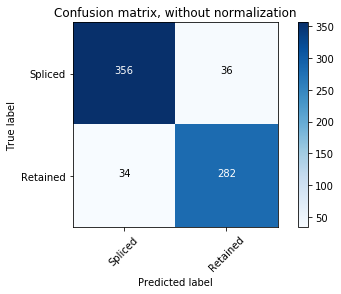

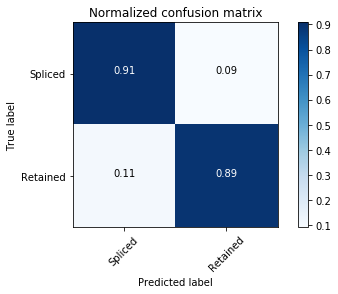

In [82]:
np.set_printoptions(precision=2)
class_names=np.array(['Spliced', 'Retained'])
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### F1-Score
$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

$Precision = \frac{TP}{TP + FP}$

$Recall = \frac{TP}{TP + TN}$

$F1-score =2 \times {\frac{2}{\frac{1}{Recall} + \frac{1}{Precision}}} = 2 \times{\frac{Precision \times Recall}{Precision + Recall}}$

In [83]:
from sklearn.metrics import precision_recall_fscore_support
precision,recall,f1_score,support=precision_recall_fscore_support(y_test_decode, y_pred_decode, average='macro')
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1_score))

Precision: 0.8998064828253507
Recall: 0.9002841642986308
F1 Score: 0.9000379194333061


### ROC Curve and AUC

In [84]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [85]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

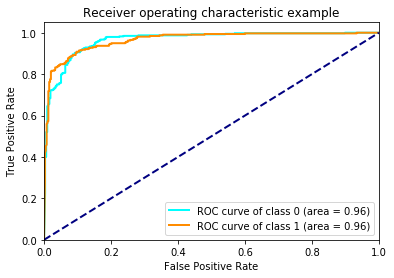

In [86]:
plt.figure()
lw = 2
#plt.plot(fpr[0], tpr[0], color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
colors = cycle(['aqua', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 10-fold Cross-Validation

In [87]:
from sklearn.model_selection import StratifiedKFold

In [88]:
def cross_validation_scores(score_list, mode):
    """
    Print the acc and auc of cross-validation data
    """
    score_array = np.asarray(score_list)
    if mode == 'percentage':
        score = '%.2f +- %.2f%%' % (np.mean(score_array)*100, np.std(score_array)*100)
    elif mode == 'decimal':
        score = '%.3f +- %.3f' % (np.mean(score_array), np.std(score_array))
    return score

In [89]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=6666)
print('%d-fold cross validation'%10)

10-fold cross validation


In [90]:
train_features, train_labels = pickle.load(open('./dataset/validation.p', mode='rb'))
for batch_id in range(1,12+1):
    filename = './dataset/train_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    train_features = np.vstack([train_features,features])
    train_labels=np.vstack([train_labels,labels])

In [91]:
train_features.shape

(3078, 307, 2500)

In [92]:
def DeepTf(X, keep_prob_1, keep_prob_2, is_training=False):
    """
    Create a convolutional/dense neural network model
    
    Arguments:
    : x: Placeholder tensor that holds data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : is_training: Placeholder bool that hold the flag to determine training is True or False, default is False
    
    Returns:
    : Tensor that represents logits
    """
    
    with tf.name_scope("CNN"):
    
        with tf.variable_scope('conv1'):
            X = conv1d(X, conv_num_outputs=128, conv_ksize=7, conv_strides=1, is_training=is_training, padding = 'SAME', l2_regularize=True, wd=0.001)
            X = max_pooling1d(X, pool_ksize=3, pool_strides=1)
            X = tf.nn.dropout(X, keep_prob_2)

        X = flatten(X)
        
        with tf.variable_scope('fc1'):
            X = fully_conn(X, num_outputs=128, is_training= is_training, l2_regularize=True, wd=0.001)
            X = tf.nn.dropout(X, keep_prob_2)
        with tf.variable_scope('fc2'):
            X = fully_conn(X, num_outputs=256, is_training = is_training, l2_regularize=True, wd=0.001)
            X = tf.nn.dropout(X, keep_prob_2)
            
        X = output(X, 2)
        
    
    return X

In [93]:
n_classes = 2
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(n_classes))
train_labels_decode = label_binarizer.inverse_transform(train_labels)
crossvalidation_loss_CNN = []
crossvalidation_acc_CNN = []
fold=1
for train_index, valid_index in skf.split(train_features, train_labels_decode):
    x_train, valid_features = train_features[train_index], train_features[valid_index]
    y_train, valid_labels = train_labels[train_index], train_labels[valid_index]
    #print(x_train.shape)
    #print(x_valid.shape)
    x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training = build_op()
    print('Training for the %d th-fold...'%fold)
    with tf.Session() as sess:
        # Initializing the variables
        sess.run(tf.global_variables_initializer())
        learning_rate = learning_rate_init
        for epoch in range(epochs):
            for batch_features, batch_labels in batch_features_labels(x_train, y_train, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, learning_rate)
            print('Epoch {:>2}  '.format(epoch + 1), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy, learning_rate, valid=(valid_features, valid_labels))
        val_loss = sess.run(cost, feed_dict={x: valid_features, y: valid_labels, keep_prob_1:1.0, keep_prob_2:1.0, is_training: False})
        val_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob_1:1.0, keep_prob_2:1.0, is_training: False})
    # Logs for each fold
    crossvalidation_loss_CNN.append(val_loss)
    crossvalidation_acc_CNN.append(val_acc)
    fold+=1
avg_loss_CNN = cross_validation_scores(crossvalidation_loss_CNN, 'decimal')
avg_acc_CNN = cross_validation_scores(crossvalidation_acc_CNN, 'percentage')
print('Loss: {}'.format(avg_loss_CNN))
print('Accuracy: {}'.format(avg_acc_CNN))

Training for the 1 th-fold...
Epoch  1  Loss:     0.6330 Accuracy: 0.6463 ----- Valid Loss:     0.6438 Valid Accuracy: 0.7045
Epoch  2  Loss:     0.4447 Accuracy: 0.7927 ----- Valid Loss:     0.6391 Valid Accuracy: 0.6071
Epoch  3  Loss:     0.3409 Accuracy: 0.8659 ----- Valid Loss:     0.6213 Valid Accuracy: 0.7890
Epoch  4  Loss:     0.2649 Accuracy: 0.8902 ----- Valid Loss:     0.6011 Valid Accuracy: 0.8279
Epoch  5  Loss:     0.1864 Accuracy: 0.9268 ----- Valid Loss:     0.5891 Valid Accuracy: 0.6916
Epoch  6  Loss:     0.1471 Accuracy: 0.9512 ----- Valid Loss:     0.5320 Valid Accuracy: 0.7695
Epoch  7  Loss:     0.1159 Accuracy: 0.9268 ----- Valid Loss:     0.4982 Valid Accuracy: 0.7468
Epoch  8  Loss:     0.0858 Accuracy: 0.9634 ----- Valid Loss:     0.4138 Valid Accuracy: 0.8312
Epoch  9  Loss:     0.0566 Accuracy: 0.9756 ----- Valid Loss:     0.3667 Valid Accuracy: 0.8571
Epoch 10  Loss:     0.0316 Accuracy: 1.0000 ----- Valid Loss:     0.3282 Valid Accuracy: 0.8636
Epoch 11  

Training for the 8 th-fold...
Epoch  1  Loss:     0.6446 Accuracy: 0.6220 ----- Valid Loss:     0.6742 Valid Accuracy: 0.5455
Epoch  2  Loss:     0.4197 Accuracy: 0.8537 ----- Valid Loss:     0.6620 Valid Accuracy: 0.5325
Epoch  3  Loss:     0.3163 Accuracy: 0.9268 ----- Valid Loss:     0.6366 Valid Accuracy: 0.6818
Epoch  4  Loss:     0.2344 Accuracy: 0.9024 ----- Valid Loss:     0.6103 Valid Accuracy: 0.7760
Epoch  5  Loss:     0.1843 Accuracy: 0.9268 ----- Valid Loss:     0.5646 Valid Accuracy: 0.8377
Epoch  6  Loss:     0.1403 Accuracy: 0.9268 ----- Valid Loss:     0.5133 Valid Accuracy: 0.8247
Epoch  7  Loss:     0.0707 Accuracy: 0.9634 ----- Valid Loss:     0.4605 Valid Accuracy: 0.8182
Epoch  8  Loss:     0.0548 Accuracy: 0.9878 ----- Valid Loss:     0.4144 Valid Accuracy: 0.8182
Epoch  9  Loss:     0.0469 Accuracy: 0.9878 ----- Valid Loss:     0.3941 Valid Accuracy: 0.8182
Epoch 10  Loss:     0.0331 Accuracy: 0.9878 ----- Valid Loss:     0.3470 Valid Accuracy: 0.8506
Epoch 11  

In [94]:
def DeepTf(X, keep_prob_1, keep_prob_2, is_training=False):
    """
    Create a convolutional/dense neural network model
    
    Arguments:
    : x: Placeholder tensor that holds data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : is_training: Placeholder bool that hold the flag to determine training is True or False, default is False
    
    Returns:
    : Tensor that represents logits
    """
    
    with tf.name_scope("DNN"):
        
        X = flatten(X)
        
        with tf.variable_scope('fc1'):
            X = fully_conn(X, num_outputs=128, is_training= is_training, l2_regularize=True, wd=0.01)
            X = tf.nn.dropout(X, keep_prob_1)
        with tf.variable_scope('fc2'):
            X = fully_conn(X, num_outputs=256, is_training = is_training, l2_regularize=True, wd=0.01)
            X = tf.nn.dropout(X, keep_prob_1)
        with tf.variable_scope('fc3'):
            X = fully_conn(X, num_outputs=512, is_training = is_training, l2_regularize=True, wd=0.01)
            X = tf.nn.dropout(X, keep_prob_2)
        with tf.variable_scope('fc4'):
            X = fully_conn(X, num_outputs=1024, is_training = is_training, l2_regularize=True, wd=0.01)
            X = tf.nn.dropout(X, keep_prob_2)
            
        X = output(X, 2)
        
    return X

In [95]:
n_classes = 2
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(n_classes))
train_labels_decode = label_binarizer.inverse_transform(train_labels)
crossvalidation_loss_DNN = []
crossvalidation_acc_DNN = []
fold=1
for train_index, valid_index in skf.split(train_features, train_labels_decode):
    x_train, valid_features = train_features[train_index], train_features[valid_index]
    y_train, valid_labels = train_labels[train_index], train_labels[valid_index]
    #print(x_train.shape)
    #print(x_valid.shape)
    x, y, keep_prob_1, keep_prob_2, lr, summary, optimizer, cost, accuracy, is_training = build_op()
    print('Training for the %d th-fold...'%fold)
    with tf.Session() as sess:
        # Initializing the variables
        sess.run(tf.global_variables_initializer())
        learning_rate = learning_rate_init
        for epoch in range(epochs):
            for batch_features, batch_labels in batch_features_labels(x_train, y_train, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, learning_rate)
            print('Epoch {:>2}  '.format(epoch + 1), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy, learning_rate, valid=(valid_features, valid_labels))
        val_loss = sess.run(cost, feed_dict={x: valid_features, y: valid_labels, keep_prob_1:1.0, keep_prob_2:1.0, is_training: False})
        val_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob_1:1.0, keep_prob_2:1.0, is_training: False})
    # Logs for each fold
    crossvalidation_loss_DNN.append(val_loss)
    crossvalidation_acc_DNN.append(val_acc)
    fold+=1
avg_loss_DNN = cross_validation_scores(crossvalidation_loss_DNN, 'decimal')
avg_acc_DNN = cross_validation_scores(crossvalidation_acc_DNN, 'percentage')
print('Loss: {}'.format(avg_loss_DNN))
print('Accuracy: {}'.format(avg_acc_DNN))

Training for the 1 th-fold...
Epoch  1  Loss:     0.5003 Accuracy: 0.8293 ----- Valid Loss:     0.4741 Valid Accuracy: 0.7922
Epoch  2  Loss:     0.2033 Accuracy: 0.9512 ----- Valid Loss:     0.3405 Valid Accuracy: 0.9058
Epoch  3  Loss:     0.0405 Accuracy: 0.9756 ----- Valid Loss:     0.3681 Valid Accuracy: 0.9123
Epoch  4  Loss:     0.0347 Accuracy: 0.9756 ----- Valid Loss:     0.4573 Valid Accuracy: 0.8961
Epoch  5  Loss:     0.0008 Accuracy: 1.0000 ----- Valid Loss:     0.5329 Valid Accuracy: 0.8831
Epoch  6  Loss:     0.0011 Accuracy: 1.0000 ----- Valid Loss:     0.3701 Valid Accuracy: 0.9058
Epoch  7  Loss:     0.0280 Accuracy: 0.9878 ----- Valid Loss:     0.3557 Valid Accuracy: 0.9156
Epoch  8  Loss:     0.1812 Accuracy: 0.9634 ----- Valid Loss:     0.3556 Valid Accuracy: 0.9058
Epoch  9  Loss:     0.0286 Accuracy: 0.9878 ----- Valid Loss:     0.3861 Valid Accuracy: 0.8961
Epoch 10  Loss:     0.0793 Accuracy: 0.9756 ----- Valid Loss:     0.3705 Valid Accuracy: 0.8961
Epoch 11  

Training for the 8 th-fold...
Epoch  1  Loss:     0.8066 Accuracy: 0.7561 ----- Valid Loss:     0.6632 Valid Accuracy: 0.6688
Epoch  2  Loss:     0.3060 Accuracy: 0.9390 ----- Valid Loss:     0.4152 Valid Accuracy: 0.8701
Epoch  3  Loss:     0.1221 Accuracy: 0.9634 ----- Valid Loss:     0.6397 Valid Accuracy: 0.8669
Epoch  4  Loss:     0.0070 Accuracy: 1.0000 ----- Valid Loss:     0.7144 Valid Accuracy: 0.8994
Epoch  5  Loss:     0.1369 Accuracy: 0.9878 ----- Valid Loss:     0.5732 Valid Accuracy: 0.8896
Epoch  6  Loss:     0.1057 Accuracy: 0.9878 ----- Valid Loss:     0.5657 Valid Accuracy: 0.8961
Epoch  7  Loss:     0.0706 Accuracy: 0.9878 ----- Valid Loss:     0.4497 Valid Accuracy: 0.8896
Epoch  8  Loss:     0.0986 Accuracy: 0.9878 ----- Valid Loss:     0.4459 Valid Accuracy: 0.8701
Epoch  9  Loss:     0.0804 Accuracy: 0.9878 ----- Valid Loss:     0.4691 Valid Accuracy: 0.8929
Epoch 10  Loss:     0.0079 Accuracy: 1.0000 ----- Valid Loss:     0.4140 Valid Accuracy: 0.8864
Epoch 11  

In [96]:
print('Loss: {}'.format(avg_loss_CNN))
print('Accuracy: {}'.format(avg_acc_CNN))

Loss: 0.327 +- 0.040
Accuracy: 85.57 +- 2.37%


In [97]:
print('Loss: {}'.format(avg_loss_DNN))
print('Accuracy: {}'.format(avg_acc_DNN))

Loss: 0.386 +- 0.075
Accuracy: 88.37 +- 1.52%
